###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 1: Music genre classification with naive Bayes


**Student ID(s):** 1072476, 1172648


## Section 0: Helper Functions

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

### Preprocess

In [3]:
# Data Preprocessing

"""Returns data in input file names as pandas dataframes."""
def preprocess(train_file_name, test_file_name):
    # put data into dataframes, remove the first column (filename)
    return pd.read_csv(train_file_name).iloc[:,1:], pd.read_csv(test_file_name).iloc[:,1:]

In [4]:
# Naive Bayes Model Training

""" Calculate the prior probability of all the class labels for the naive bayes
    model. The argument of the function is the train dataframe and the output
    is a dictionary containing the prior probabilities of each label """
def calculate_prior_prob(train_df : pd.DataFrame):
    prior_prob = {}
    label_instances = train_df["label"]
    labels = np.unique(label_instances)
    total_instances = label_instances.count()
    
    # iterate over all the labels and calculate the prior probabilities
    for label in labels:
        label_count = (label_instances == label).sum()
        prior_prob[label] = label_count / total_instances

    return prior_prob

""" Calculate the parameters of a Gaussian distribution for likelihood 
    probabilities of all the features in the dataset conditional on the class 
    label for the model. The argument of the function is the train dataframe 
    and the output is a 2D dictionary containing the means and 
    standard deviations
    """
def calculate_gaussian_parameters(train_df : pd.DataFrame):
    gaussian_parameters = {}
    features = train_df.columns[:-1]
    labels = np.unique(train_df["label"])

    # iterate over each feature and then each label
    for feature in features:
        gaussian_parameters[feature] = {}

        for label in labels:
            # get all the feature values that have the label and compute the mean and standard deviation
            instances_in_label = train_df[train_df["label"] == label]
            values_in_label = instances_in_label[feature][instances_in_label[feature].notnull()]
            count = len(values_in_label)
            
            likelihood_mean = values_in_label.sum() / count
            likelihood_sd = np.sqrt(values_in_label.apply(lambda x: (x - likelihood_mean)**2).sum() / (count - 1))
            gaussian_parameters[feature][label] = (likelihood_mean, likelihood_sd)

    return gaussian_parameters

""" Probability density function of the Gaussian distribution. Takes the mean,
    standard deviation and x_value and returns the value of the density function 
    at the x_value. If take_log argument is true, return the log of 
    the density value """
def gaussian_pdf(mean, sd, x_value, take_log = False):
    if take_log:
        return -(x_value - mean)**2/(2*sd**2) - np.log(sd*np.sqrt(2*np.pi))
    else:
        return (1/sd*np.sqrt(2*np.pi))*np.exp(-(x_value - mean)**2/(2*sd**2))

""" Trains a Naive Bayes model based on the input dataframe. Class labels must be in a column named \"label\".
    The model is a tuple which contains a dictionary of prior probabilities (keys are class labels), and 
    a dictionary (keys are feature names) of dictionaries (keys are class labels) which contain
    the mean and standard deviation of the gaussian likelihood estimate."""
def train(train_df):
    return calculate_prior_prob(train_df), calculate_gaussian_parameters(train_df)


### Predict

In [5]:
# Naive Bayes Model Application

# Given an input Naive Bayes Model and a pdf, predicts class of a test instance.
def predict_instance(instance, priors, likelihood_pdf = None, likelihood_pdf_parameters = None, use_gaussian_likelihood = True, likelihood_kde = None):    
    if use_gaussian_likelihood:
        labels = likelihood_pdf_parameters[list(likelihood_pdf_parameters.keys())[0]].keys()
    else:
        labels = likelihood_kde[list(likelihood_kde.keys())[0]].keys()
    best, best_score = [], None
    for label in labels:
        # Calculate the best score for the current class label
        score = np.log(priors[label])
        for feature in instance[instance.notnull()].index:
            if use_gaussian_likelihood:
                mean = likelihood_pdf_parameters[feature][label][0]
                sd = likelihood_pdf_parameters[feature][label][1]
                score += likelihood_pdf(mean, sd, instance[feature], True)
            else:
                score += likelihood_kde[feature][label].score(np.array(instance[feature]).reshape(-1,1))
        # Keep track of the best class labels
        if best_score == None or score > best_score:
            best = [label]
            best_score = score
        elif score == best_score:
            best.append(label)
    return random.choice(best)
    
# Predicts classes for each instance in the test dataset
def predict(test_df, priors, likelihood_pdf = None, likelihood_pdf_parameters = None, use_gaussian_likelihood = True, likelihood_kde = None):
    test_df_no_labels = test_df.loc[:, test_df.columns != "label"]
    return test_df_no_labels.apply(lambda instance: predict_instance(instance, priors, likelihood_pdf, likelihood_pdf_parameters, use_gaussian_likelihood, likelihood_kde),
                                   axis='columns')

### Evaluate

In [21]:
# Model Evaluation

"""Calculates accuracy, precision and recall associated with the pair of true and predicted lables.
    If the positive label is not specified then multiclass metrics are used."""
def evaluate(true_labels, predicted_labels, positive_label=None):
    labels = np.unique(true_labels)
    
    # Count the number of occurrences for each combination of true and predicted labels
    combination_counts = pd.concat([true_labels, predicted_labels], axis="columns", ignore_index=True).value_counts()
    
    # Set the count of any combination that wasn't seen to 0
    index = pd.MultiIndex.from_tuples(itertools.product(labels, labels), names=["true_labels", "predicted_labels"])
    confusion_matrix = combination_counts.reindex(index=index, fill_value=0)
    
    evaluation_metrics = dict()

    # Determine the positive labels to be used in multi/single class metrics 
    if positive_label != None:
        positive_labels = [positive_label]
    else:
        positive_labels = list(labels)
        
    # Do one vs rest for each positive label
    precisions, recalls, f_1s = [], [], []
    for label in positive_labels:
        negative_labels = [other_label for other_label in labels if other_label != label]
        
        true_positive = confusion_matrix[label, label]
        true_negative = sum(confusion_matrix.loc[[(negative_label, negative_label) for negative_label in negative_labels]])
        false_positive = sum(confusion_matrix.loc[[(negative_label, label) for negative_label in negative_labels]])
        false_negative = sum(confusion_matrix.loc[[(label, negative_label) for negative_label in negative_labels]])
        
        recall = true_positive / (true_positive + false_negative)
        recalls.append(recall)
        
        if true_positive + false_positive != 0:
            precision = true_positive / (true_positive + false_positive)
            precisions.append(precision)
            if precision + recall != 0:
                f_1 = 2 * precision * recall / (precision + recall) 
            else:
                f_1 = 0
            f_1s.append(f_1)
            
            #evaluation_key = "stats_" + label
            #evaluation_metrics[evaluation_key] = dict()
            #evaluation_metrics[evaluation_key]["recall_" + label] = recall
            #evaluation_metrics[evaluation_key]["precision_" + label] = precision
            #evaluation_metrics[evaluation_key]["f_1_" + label] = f_1
            
            evaluation_metrics["recall_" + label] = recall
            evaluation_metrics["precision_" + label] = precision
            evaluation_metrics["f_1_" + label] = f_1
            
    evaluation_metrics["accuracy"] = sum(confusion_matrix[label, label] for label in labels) / confusion_matrix.sum()
    #evaluation_metrics["confusion_matrix"] = confusion_matrix
    
    if positive_label != None:
        # There is only one element in each of precisions, recalls, f_1s
        evaluation_metrics["precision"] = precisions[0]
        evaluation_metrics["recall"] = recalls[0]
        evaluation_metrics["f_1"] = f_1s[0]
    # Multi-class metrics are different
    else:
        evaluation_metrics["macro_precision"] = sum(precisions) / len(precisions)
        evaluation_metrics["macro_recall"] =  sum(recalls) / len(recalls)
        evaluation_metrics["macro_f_1"] = sum(f_1s) / len(f_1s)
    
    return evaluation_metrics

## Section 1: Task 1. Pop vs. classical music classification

### Q1

In [9]:
# Compute and report the accuracy, precision, and recall of the model.
train_df, test_df = preprocess('COMP30027_2023_asst1_data\pop_vs_classical_train.csv','COMP30027_2023_asst1_data\pop_vs_classical_test.csv')
priors, likelihood_param = train(train_df)
predicted_labels = predict(test_df, priors, gaussian_pdf, likelihood_param)
evaluation_metrics = evaluate(test_df['label'], predicted_labels, 'classical')
evaluation_metrics

{'recall_classical': 1.0,
 'precision_classical': 0.9523809523809523,
 'f_1_classical': 0.975609756097561,
 'accuracy': 0.9767441860465116,
 'confusion_matrix': true_labels  predicted_labels
 classical    classical           20
              pop                  0
 pop          classical            1
              pop                 22
 dtype: int64,
 'precision': 0.9523809523809523,
 'recall': 1.0,
 'f_1': 0.975609756097561}

### Q2

In [12]:
""" Plots the graphs of the pdf that are used for the likelihood"""
def pdf_graphs_constructor(train_df, feature, gaussian_param, labels, ax):

    # determine a range of x-values for the plots
    if (np.min(train_df[feature]) >= 0):
        lower =  0
    else:
        lower =  np.min(train_df[feature]) + 0.25 * np.min(train_df[feature])
    upper = np.max(train_df[feature]) + 0.25 * np.max(train_df[feature])
    x_values = np.arange(lower, upper, (upper - lower) / 150)

    # for each label, calculate the values of the pdf using the x-value 
    # and plot the graph
    for label in labels:
        mean = gaussian_param[feature][label][0]
        sd = gaussian_param[feature][label][1]
        y_values = np.array([gaussian_pdf(mean, sd, x, False) for x in x_values])
        ax.plot(x_values, y_values, label=label)
    
    ax.legend()
    ax.set_xlabel(feature.replace('_',' '))
    ax.set_ylabel('density')
    ax.set_title('Likelihood Distributions for {}'.format(feature.replace('_',' ')))

# plot the likelihood distribution for the three features
fig, axes = plt.subplots(1, 3, figsize = (20, 5),layout='constrained')
labels = np.unique(train_df['label'])
pdf_graphs_constructor(train_df, 'spectral_centroid_mean', likelihood_param, labels, axes[0])
pdf_graphs_constructor(train_df, 'harmony_mean', likelihood_param, labels, axes[1])
pdf_graphs_constructor(train_df, 'tempo', likelihood_param, labels, axes[2])
plt.show()
#fig.savefig('likelihood_plots_q2.png')



TypeError: __init__() got an unexpected keyword argument 'layout'

## Section 2: Task 2. 10-way music genre classification

In [10]:
# Train and test naive bayes model on the gztan dataset

train_df, test_df = preprocess('COMP30027_2023_asst1_data\gztan_train.csv','COMP30027_2023_asst1_data\gztan_test.csv')
priors, likelihood_param = train(train_df)
predicted_labels = predict(test_df, priors, gaussian_pdf, likelihood_param)
evaluation_metrics = evaluate(test_df['label'], predicted_labels)
evaluation_metrics

{'recall_blues': 0.15789473684210525,
 'precision_blues': 0.42857142857142855,
 'f_1_blues': 0.23076923076923078,
 'recall_classical': 0.85,
 'precision_classical': 0.8947368421052632,
 'f_1_classical': 0.8717948717948718,
 'recall_country': 0.6875,
 'precision_country': 0.3793103448275862,
 'f_1_country': 0.4888888888888889,
 'recall_disco': 0.45454545454545453,
 'precision_disco': 0.47619047619047616,
 'f_1_disco': 0.46511627906976744,
 'recall_hiphop': 0.2857142857142857,
 'precision_hiphop': 0.5,
 'f_1_hiphop': 0.36363636363636365,
 'recall_jazz': 0.3333333333333333,
 'precision_jazz': 0.5,
 'f_1_jazz': 0.4,
 'recall_metal': 0.9,
 'precision_metal': 0.3829787234042553,
 'f_1_metal': 0.5373134328358209,
 'recall_pop': 0.6956521739130435,
 'precision_pop': 0.8,
 'f_1_pop': 0.7441860465116279,
 'recall_reggae': 0.6428571428571429,
 'precision_reggae': 0.5625,
 'f_1_reggae': 0.6000000000000001,
 'recall_rock': 0.1111111111111111,
 'precision_rock': 0.17647058823529413,
 'f_1_rock': 0.1

### Q3
Compare the performance of the full model to a 0R baseline and a one-attribute baseline. The one-attribute baseline should be the best possible naive Bayes model which uses only a prior and a single attribute. In your write-up, explain how you implemented the 0R and one-attribute baselines.

0-R Baseline
Most Frequent Classes: ['reggae']
Accuracy             : 0.07000000000000002
Precision            : 0.07000000000000002
Recall               : 0.09999999999999999
F_1                  : 0.13084112149532712
One-Attribute Baseline
Attribute: spectral_bandwidth_mean
Accuracy : 0.31
Precision: 0.33105079006407845
Recall   : 0.2974087392394028
F_1      : 0.41046230962020436


NameError: name 'pdf_graphs_constructor' is not defined

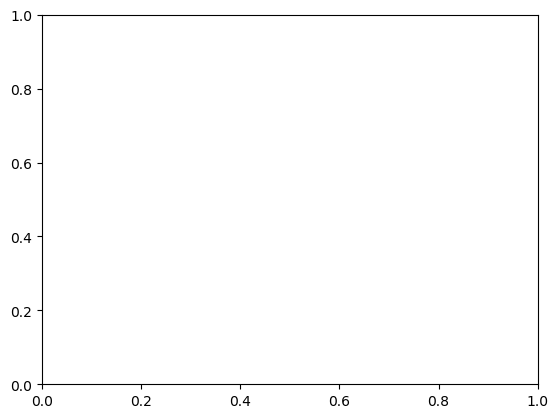

In [11]:
""" Given a collection of labels, find the most frequent label. If there are
    multiple most frequent labels, the function randomly chooses one
"""
def get_most_frequent_label(labels):
    most_frequent_labels = []
    most_frequent_indices = []
    max_count = 0
    unique_labels, counts = np.unique(labels, return_counts=True)

    # find the indices with the highest count
    for i in range(0, len(counts)):
        if counts[i] > max_count:
            most_frequent_indices = [i]
            max_count = counts[i]
        elif counts[i] == max_count:
            most_frequent_indices.append(i)
    
    # using the indices, find the most frequent labels        
    for index in most_frequent_indices:
        most_frequent_labels.append(unique_labels[index])

    return random.choice(most_frequent_labels)

""" Predict the labels of the test data using a 0R baseline
"""
def zero_r_predict(train_df, test_df):
    most_frequent_label = get_most_frequent_label(train_df['label'])
    return pd.Series([most_frequent_label for i in range(0, len(test_df))])

""" Predict the labels of the test data using a one-attribute baseline
"""
def one_attribute_predict_and_evaluate(train_df, test_df):
    attributes = train_df.columns[:-1]
    best_accuracy = -1
    best_attribute = ''
    evaluate_best_attribute = {}

    # for each feature, predict the label of the test data
    for attribute in attributes:
        one_attribute_predicted_labels = predict(test_df[[attribute, 'label']], priors, gaussian_pdf, likelihood_param)
        evaluate_one_attribute = evaluate(test_df['label'], one_attribute_predicted_labels)
        
        if evaluate_one_attribute['accuracy'] > best_accuracy:
            best_attribute = attribute
            evaluate_best_attribute = evaluate_one_attribute
            best_accuracy = evaluate_one_attribute['accuracy']

    return best_attribute, evaluate_best_attribute

most_frequent_labels, accuracies, precisions, recalls, f_1s = [], [], [], [], []
for i in range(10):
    zero_r_predicted_labels = zero_r_predict(train_df, test_df)
    evaluate_zero_r = evaluate(test_df['label'], zero_r_predicted_labels)
    most_frequent_labels.append(zero_r_predicted_labels.iloc[0])
    accuracies.append(evaluate_zero_r['accuracy'])
    precisions.append(evaluate_zero_r['macro_precision'])
    recalls.append(evaluate_zero_r['macro_recall'])
    f_1s.append(evaluate_zero_r['macro_f_1'])
    
    
print(f"==============================\n"
    + f"0-R Baseline\n"
    + f"Most Frequent Classes: {np.unique(most_frequent_labels)}\n"
    + f"Accuracy             : {sum(accuracies) / len(accuracies)}\n"
    + f"Precision            : {sum(precisions) / len(precisions)}\n"
    + f"Recall               : {sum(recalls) / len(recalls)}\n"
    + f"F_1                  : {sum(f_1s) / len(f_1s)}")

evaluate_one_attribute = one_attribute_predict_and_evaluate(train_df, test_df)


print(f"==============================\n"
    + f"One-Attribute Baseline\n"
    + f"Attribute: {evaluate_one_attribute[0]}\n"
    + f"Accuracy : {evaluate_one_attribute[1]['accuracy']}\n"
    + f"Precision: {evaluate_one_attribute[1]['macro_precision']}\n"
    + f"Recall   : {evaluate_one_attribute[1]['macro_recall']}\n"
    + f"F_1      : {evaluate_one_attribute[1]['macro_f_1']}")


fig, ax = plt.subplots(1,1)
labels = np.unique(train_df['label'])
pdf_graphs_constructor(train_df, evaluate_one_attribute[0], likelihood_param, labels, ax)
evaluate_one_attribute[1]
#fig.savefig('likelihood_plots_q3.png')

### Q4
Train and test your model with a range of training set sizes by setting up your own train/test splits. With each split, use cross-fold validation so you can report the performance on the entire dataset (1000 items). You may use built-in functions to set up cross-validation splits. In your write-up, evaluate how model performance changes with training set size.

### Q5
Implement a kernel density estimate (KDE) naive Bayes model and compare its performance to your Gaussian naive Bayes model. You may use built-in functions and automatic ("rule of thumb") bandwidth selectors to compute the KDE probabilities, but you should implement the naive Bayes logic yourself. You should give the parameters of the KDE implementation (namely, what bandwidth(s) you used and how they were chosen) in your write-up.

In [20]:
from sklearn.neighbors import KernelDensity

""" Determine the kde for the likelihood probabilities of all the features in 
    the dataset conditional on the class label for the model. The argument of 
    the function is the train dataframe and the output is a 2D dictionary 
    containing the kde likelihood for feature and specific label
"""
def calculate_kde_likelihood(train_df : pd.DataFrame, bandwidth_rule):
    kde_likelihoods = {}
    features = train_df.columns[:-1]
    label_instances = train_df["label"]
    labels = np.unique(label_instances)
    bandwidths = []

    # iterate over each feature and then each label
    for feature in features:
        kde_likelihoods[feature] = {}

        for label in labels:
            # get all the feature values that have the label
            instances_in_label = train_df[train_df["label"] == label]
            values_in_label = instances_in_label[feature][instances_in_label[feature].notnull()]
            values_in_label = np.array(values_in_label).reshape(-1,1)

            if bandwidth_rule == 'silverman':
                # calculate silverman's rule of thumb for kde bandwidth
                sd = np.std(values_in_label)
                iqr = np.quantile(values_in_label, 0.75) - np.quantile(values_in_label, 0.25)
                bandwidth = 0.9*np.min([sd, iqr / 1.34])*(len(values_in_label))**(-0.2)
            else:
                # use a constant bandwidth
                bandwidth = 1.0
            
            bandwidths.append(bandwidth)

            # fit the training data to the kde
            kde_likelihoods[feature][label] = KernelDensity(bandwidth=bandwidth, kernel='gaussian').fit(values_in_label)

    return kde_likelihoods, pd.Series(bandwidths)

for bandwidth_rule in ['constant', 'silverman']:
    likelihood_kde , bandwidths = calculate_kde_likelihood(train_df, bandwidth_rule)
    predicted_labels_kde = predict(test_df, priors, use_gaussian_likelihood= False, likelihood_kde= likelihood_kde)
    evaluate_kde = evaluate(test_df['label'], predicted_labels_kde)
    print(f"==============================\n"
        + f"Kernel        : Gaussian\n"
        + f"Accuracy      : {evaluate_kde['accuracy']}\n"
        + f"Precision     : {evaluate_kde['macro_precision']}\n"
        + f"Recall        : {evaluate_kde['macro_recall']}\n"
        + f"F_1           : {evaluate_kde['macro_f_1']}\n"
        + f"Bandwidth Rule: {bandwidth_rule}\n"
        + f"Bandwidth statistics:\n"
        + bandwidths.describe().to_string())
evaluate_kde

Kernel        : Gaussian
Accuracy      : 0.19
Precision     : 0.1749951742867344
Recall        : 0.18905004331205705
F_1           : 0.18051725629887855
Bandwidth Rule: constant
Bandwidth statistics:
count    570.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Kernel        : Gaussian
Accuracy      : 0.595
Precision     : 0.6124872545231947
Recall        : 0.6015048697171123
F_1           : 0.5861952839220476
Bandwidth Rule: silverman
Bandwidth statistics:
count       570.000000
mean       7303.336180
std       46683.529236
min           0.000001
25%           1.387728
50%           5.440097
75%          14.343757
max      552245.993025


{'stats_blues': {'recall_blues': 0.2631578947368421,
  'precision_blues': 0.7142857142857143,
  'f_1_blues': 0.3846153846153846},
 'stats_classical': {'recall_classical': 0.9,
  'precision_classical': 0.9473684210526315,
  'f_1_classical': 0.9230769230769231},
 'stats_country': {'recall_country': 0.5625,
  'precision_country': 0.42857142857142855,
  'f_1_country': 0.4864864864864864},
 'stats_disco': {'recall_disco': 0.5909090909090909,
  'precision_disco': 0.5652173913043478,
  'f_1_disco': 0.5777777777777778},
 'stats_hiphop': {'recall_hiphop': 0.42857142857142855,
  'precision_hiphop': 0.5294117647058824,
  'f_1_hiphop': 0.4736842105263158},
 'stats_jazz': {'recall_jazz': 0.6111111111111112,
  'precision_jazz': 0.7333333333333333,
  'f_1_jazz': 0.6666666666666666},
 'stats_metal': {'recall_metal': 0.9,
  'precision_metal': 0.5294117647058824,
  'f_1_metal': 0.6666666666666667},
 'stats_pop': {'recall_pop': 0.782608695652174,
  'precision_pop': 0.8181818181818182,
  'f_1_pop': 0.8},


### Q6
Modify your naive Bayes model to handle missing attributes in the test data. Recall from lecture that you can handle missing attributes at test by skipping the missing attributes and computing the posterior probability from the non-missing attributes. Randomly delete some attributes from the provided test set to test how robust your model is to missing data. In your write-up, evaluate how your model's performance changes as the amount of missing data increases.

In [23]:
"""Returns a copy of the input dataframe with num random (non-label) entries changed to NaN."""
def randomly_drop_values(x, rate):
    assert(0 <= rate <= 1)
    assert(x.columns[-1] == "label")
    
    m, n = x.shape[0], x.shape[1] - 1
    num_to_drop = int(rate * m * n)
    rows, columns = [i for i in range(m)], [j for j in range(n)]
    
    all_indices = list(itertools.product(rows, columns))
    random.shuffle(all_indices)
    indices_to_drop = all_indices[:num_to_drop]
    
    y = x.copy()
    
    for i, j in indices_to_drop:
        y.iloc[i, j] = None
    
    return y


train_df, test_df = preprocess('COMP30027_2023_asst1_data\gztan_train.csv','COMP30027_2023_asst1_data\gztan_test.csv')
priors, likelihood_param = train(train_df)

for rate in [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    N = 10
    #accuracies, precisions, recalls, f_1s = [], [], [], []
    
    overall_evaluation_metrics = dict()
    
    # Train the model N times on randomly dropped data and collect its performance
    for _ in range(N):
        corrupted_test_df = randomly_drop_values(test_df, rate)
        predicted_labels = predict(corrupted_test_df, priors, gaussian_pdf, likelihood_param)
        evaluation_metrics = evaluate(test_df['label'], predicted_labels)
    
        #accuracies.append(evaluation_metrics['accuracy'])
        #precisions.append(evaluation_metrics['macro_precision'])
        #recalls.append(evaluation_metrics['macro_recall'])
        #f_1s.append(evaluation_metrics['macro_f_1'])
    
        # Collect this iterations evaluation_metrics
        for key in evaluation_metrics:
            if key not in overall_evaluation_metrics:
                overall_evaluation_metrics[key] = []
            overall_evaluation_metrics[key].append(evaluation_metrics[key])
    
    #print(f"==============================\n"
     #   + f"Drop rate: {rate * 100}%\n"
      #  + f"Accuracy : {sum(accuracies) / len(accuracies)}\n"
     #   + f"Precision: {sum(precisions) / len(precisions)}\n"
     #   + f"Recall   : {sum(recalls) / len(recalls)}\n"
     #   + f"F_1      : {sum(f_1s) / len(f_1s)}")
    
    print(f"==============================")
    print(f"Drop rate: {rate * 100}%")
    
    for key, value in overall_evaluation_metrics.items():
        print(f"{key:19}: {sum(value) / len(value):.4f}")

Drop rate: 0%
recall_blues       : 0.1579
precision_blues    : 0.4286
f_1_blues          : 0.2308
recall_classical   : 0.8500
precision_classical: 0.8947
f_1_classical      : 0.8718
recall_country     : 0.6875
precision_country  : 0.3793
f_1_country        : 0.4889
recall_disco       : 0.4545
precision_disco    : 0.4762
f_1_disco          : 0.4651
recall_hiphop      : 0.2857
precision_hiphop   : 0.5000
f_1_hiphop         : 0.3636
recall_jazz        : 0.3333
precision_jazz     : 0.5000
f_1_jazz           : 0.4000
recall_metal       : 0.9000
precision_metal    : 0.3830
f_1_metal          : 0.5373
recall_pop         : 0.6957
precision_pop      : 0.8000
f_1_pop            : 0.7442
recall_reggae      : 0.6429
precision_reggae   : 0.5625
f_1_reggae         : 0.6000
recall_rock        : 0.1111
precision_rock     : 0.1765
f_1_rock           : 0.1364
accuracy           : 0.4950
macro_precision    : 0.5101
macro_recall       : 0.5119
macro_f_1          : 0.4838
Drop rate: 10.0%
recall_blues     